# Correção automática de provas

## Imports e outras inicializações

In [1]:
import warnings
import cv2
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
print(cv2.__version__)
warnings.filterwarnings('ignore')

4.5.2


## Abrindo imagens

(1758, 820, 3)


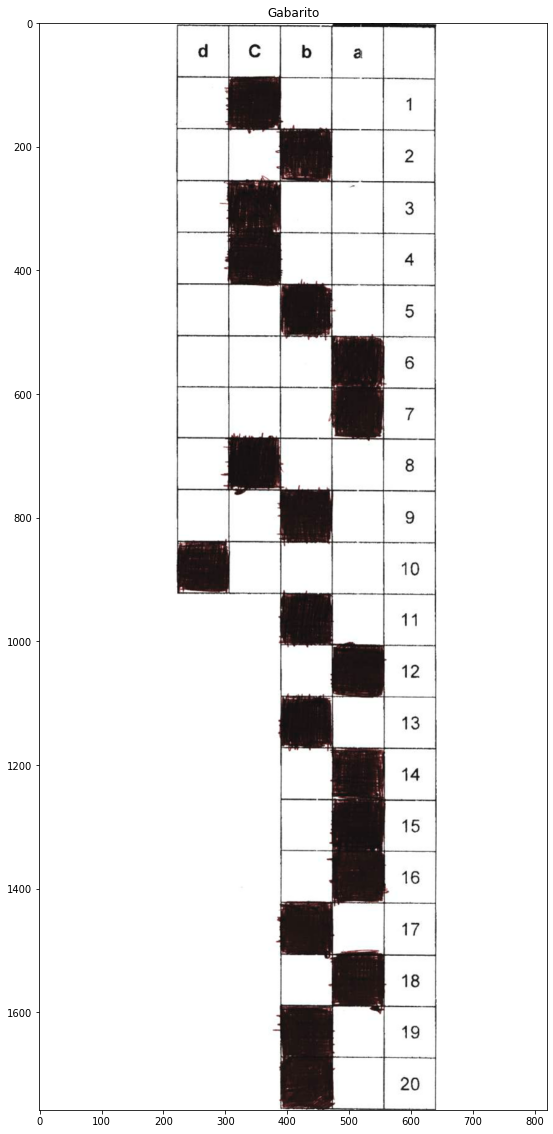

In [2]:
def abrir_imagens(img_caminho):
    imagem = cv2.imread(img_caminho, cv2.COLOR_BGR2RGB)
    if imagem is None:
        raise NameError('\nImagem não encontrada. Verifique se o caminho passado existe!')
    return imagem



imagem = abrir_imagens('./imagens/teste1.png')
print(imagem.shape)

plt.figure(figsize=(10, 20))
plt.title('Gabarito')
plt.imshow(imagem)
plt.show()

## Binarização e bordas

Converte para escala de cinza

(1758, 820)


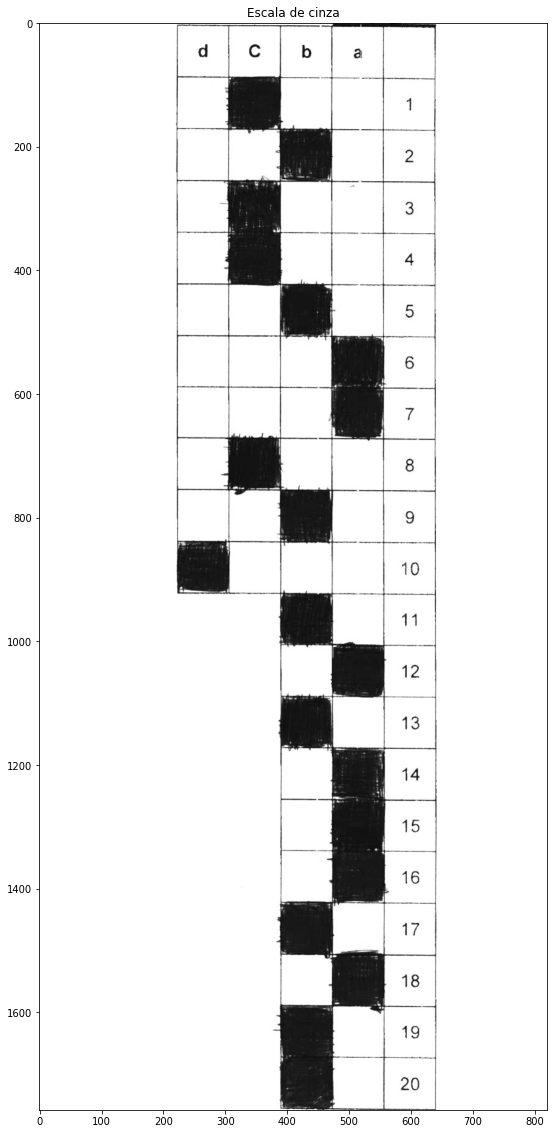

In [3]:
imagem_gray = cv2.cvtColor(imagem, cv2.COLOR_RGB2GRAY)
print(imagem_gray.shape)

plt.figure(figsize=(10, 20))
plt.title('Escala de cinza')
plt.imshow(imagem_gray, cmap='Greys_r')
plt.show()

Converte para escala preto e branco e destaca as bordas

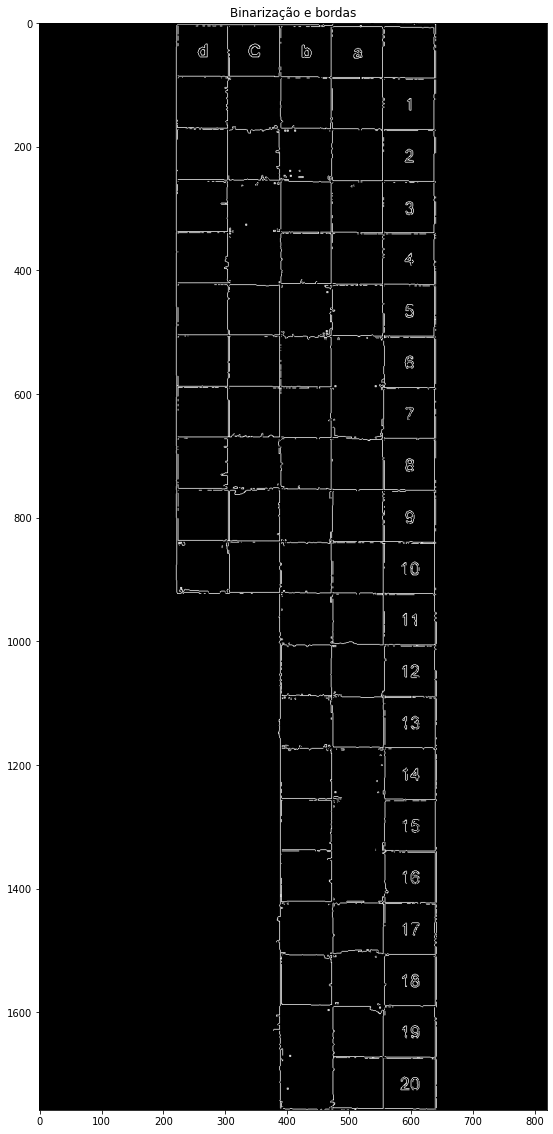

In [4]:
thresh, imagem_binaria = cv2.threshold(imagem_gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
imagem_com_borda = cv2.Canny(imagem_binaria, 100, 200)

plt.figure(figsize=(10, 20))
plt.title('Binarização e bordas')
plt.imshow(imagem_com_borda, cmap='Greys_r')
plt.show()

## Filtros morfológicos

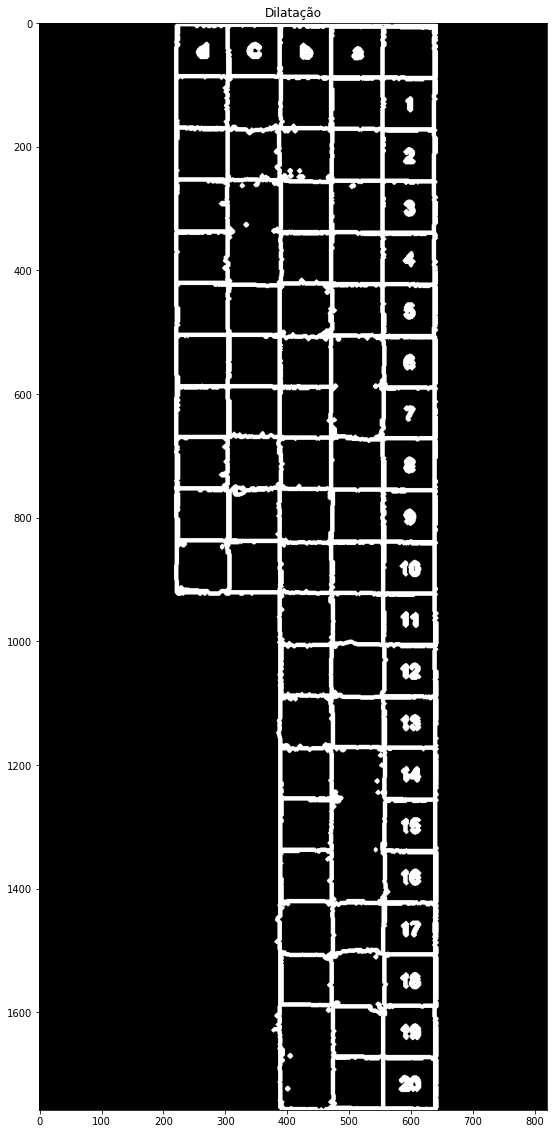

In [5]:
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
operacao_dilatar = cv2.morphologyEx(imagem_com_borda, cv2.MORPH_DILATE, kernel, iterations=3)

plt.figure(figsize=(10, 20))
plt.title('Dilatação')
plt.imshow(operacao_dilatar, cmap='Greys_r')
plt.show()

## Remoção de ruídos

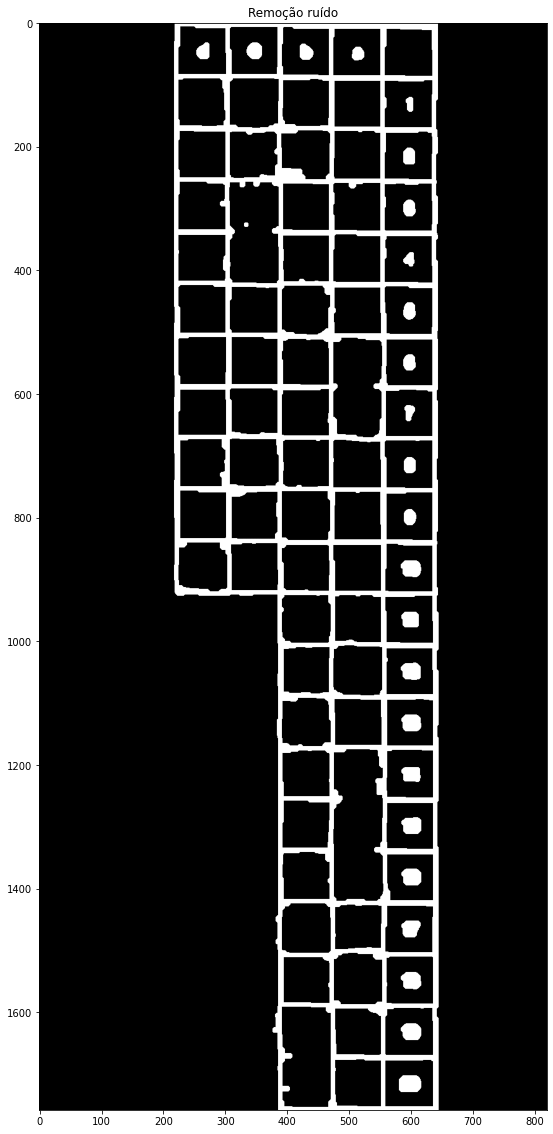

In [6]:
kernel_rect = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
operacao_close = cv2.morphologyEx(operacao_dilatar, cv2.MORPH_CLOSE, kernel_rect, iterations=3)
operacao_open = cv2.morphologyEx(operacao_close, cv2.MORPH_OPEN, kernel_rect, iterations=1)

plt.figure(figsize=(10, 20))
plt.title('Remoção ruído')
plt.imshow(operacao_open, cmap='Greys_r')
plt.show()

## FIltrando linhas de interesse

In [7]:
import math

def hough_para_cartesiano(raio, theta):
    seno = math.sin(theta)
    cosseno = math.cos(theta)    
    x = raio * cosseno
    y = raio * seno    
    return x, y


def criar_linha(ponto, theta):
    seno = math.sin(theta)
    cosseno = math.cos(theta)
    x1 = int(ponto[0] + 10000 * (-seno))
    y1 = int(ponto[1] + 10000 * (cosseno))
    x2 = int(ponto[0] - 800 * (-seno))
    y2 = int(ponto[1] - 800 * (cosseno)) 
    return (x1, y1, x2, y2)


def desenhar_linha(imagem, raio, theta):
    ponto = hough_para_cartesiano(raio, theta)
    x1, y1, x2, y2 = criar_linha(ponto, theta)    
    imagem = cv2.line(imagem, (x1, y1), (x2, y2), (0, 255, 0), 3)
    return imagem

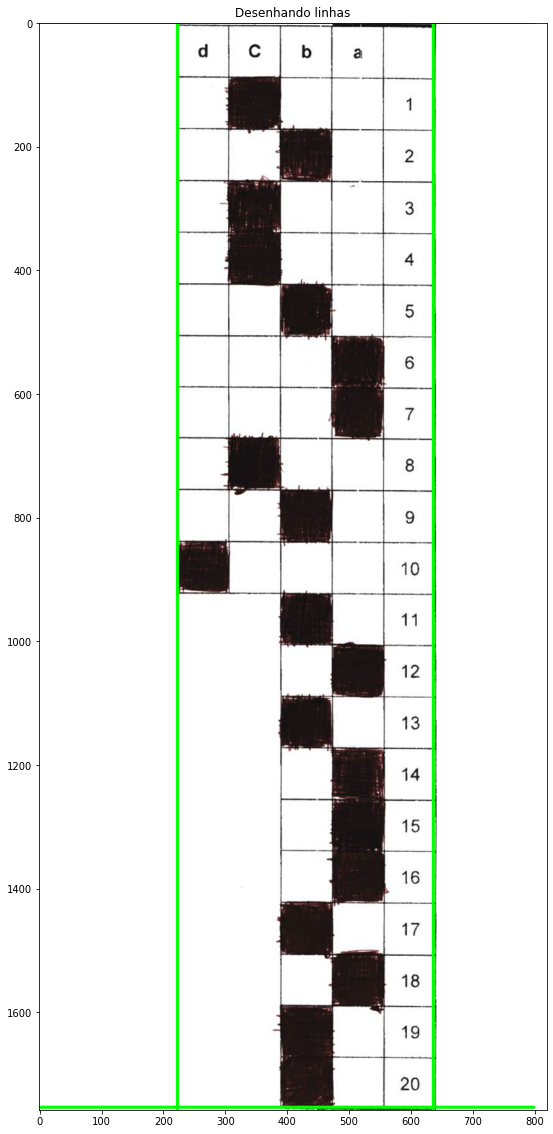

In [8]:
l_linhas = cv2.HoughLines(operacao_open, 1, np.pi/180, 80)
limites_horizontais= np.array([[imagem.size, imagem.size], [0.0, 0.0]], dtype=np.float)
limites_verticais = np.array([[imagem.size, imagem.size], [0.0, 0.0]], dtype=np.float)

for linha in l_linhas:
    for raio, theta in linha:
        if np.isclose(theta, 0.0):
            if raio < limites_verticais[0][0]:
                limites_verticais[0][0] = raio
                limites_verticais[0][1] = theta
            if raio > limites_verticais[1][0]:
                limites_verticais[1][0] = raio
                limites_verticais[1][1] = theta
            
        if np.isclose(theta, np.pi/2.0):
            if raio < limites_horizontais[0][0]:
                limites_horizontais[0][0] = raio
                limites_horizontais[0][1] = theta
            if raio > limites_horizontais[1][0]:
                limites_horizontais[1][0] = raio
                limites_horizontais[1][1] = theta
        
        
imagem_copia = imagem.copy()
for valor in range(2):
    imagem_copia = desenhar_linha(imagem_copia, limites_horizontais[valor][0], limites_horizontais[valor][1])
    imagem_copia = desenhar_linha(imagem_copia, limites_verticais[valor][0], limites_verticais[valor][1])
        
        
plt.figure(figsize=(10, 20))
plt.title('Desenhando linhas')
plt.imshow(imagem_copia, cmap='Greys_r')
plt.show()

### Interseção da imagem

In [9]:
def encontrar_intersecao(raio1, raio2):
    resultante = math.sqrt((raio1**2+raio2**2))
    theta = math.atan((raio1/raio2))
    return resultante, theta

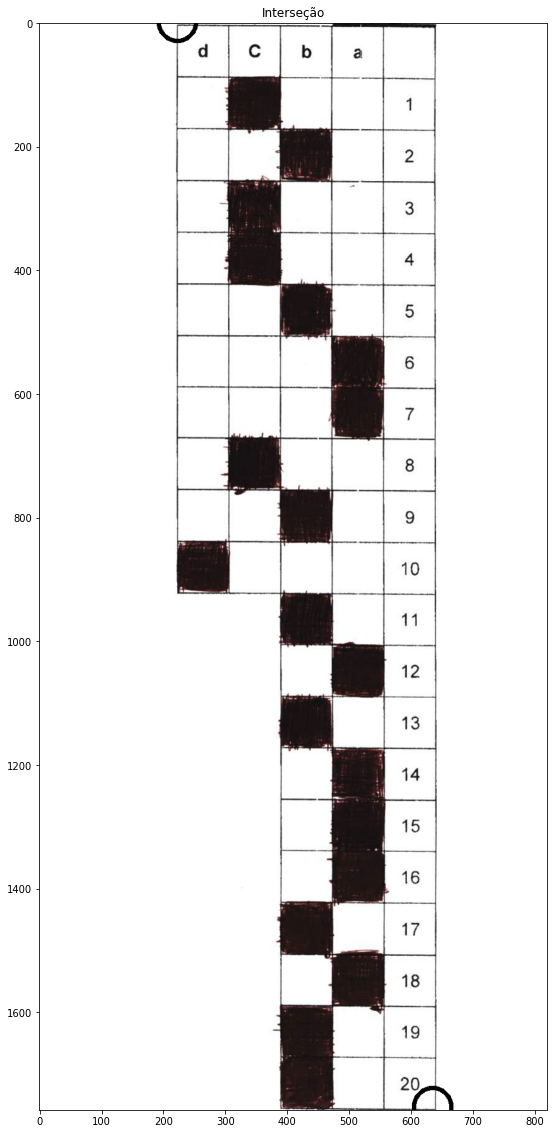

In [10]:
raio_se, theta_se = encontrar_intersecao(limites_horizontais[0][0], limites_verticais[0][0])
x_se, y_se = hough_para_cartesiano(raio_se, theta_se)

raio_id, theta_id = encontrar_intersecao(limites_horizontais[1][0], limites_verticais[1][0])
x_id, y_id = hough_para_cartesiano(raio_id, theta_id)

imagem_copia = imagem.copy()
imagem_copia = cv2.circle(imagem_copia, (int(x_se), int(y_se)), 30, (0, 0, 0), 5)
imagem_copia = cv2.circle(imagem_copia, (int(x_id), int(y_id)), 30, (0, 0, 0), 5)

plt.figure(figsize=(10, 20))
plt.title('Interseção')
plt.imshow(imagem_copia, cmap='Greys_r')
plt.show()

### Crop da imagem

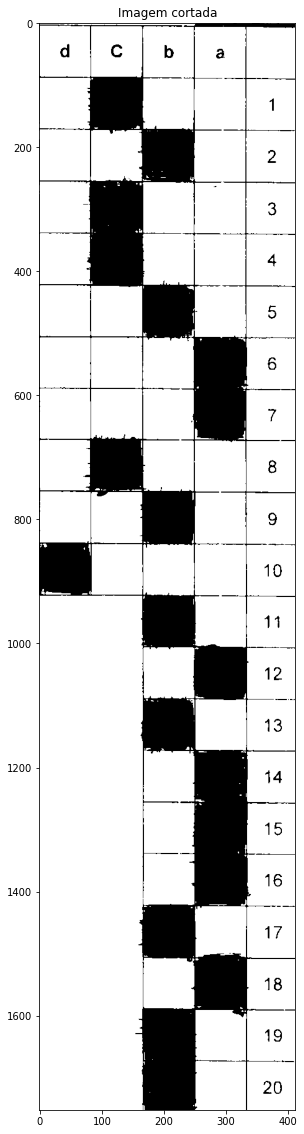

In [11]:
nova_imagem = imagem_binaria[int(y_se):int(y_id), int(x_se):int(x_id)]

plt.figure(figsize=(10, 20))
plt.title('Imagem cortada')
plt.imshow(nova_imagem, cmap='Greys_r')
plt.show()

### Extraindo áreas de interesse e questões